<a href="https://colab.research.google.com/github/hassen8/emotion_recognotion_bias_auditing/blob/master/notebooks/deepface_on_RAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to drive then download, unzip the dataset then copy the label file

In [1]:
#before this step make sure you add shortcuts of the EmoLabel and Image folders to your Drive
from google.colab import drive
drive.mount('/content/drive/')

# Then access files like:
# /content/drive/MyDrive/your_dataset.csv

Mounted at /content/drive/


In [ ]:
# use the paths of your own drive
!unzip /content/drive/MyDrive/drive_bys/Image/aligned.zip

In [3]:
# same here, use your own path
!cp /content/drive/MyDrive/drive_bys/EmoLabel/list_patition_label.txt .

In [4]:
#path to the images and labelfile
image_folder = 'aligned'
label_file = 'list_patition_label.txt'

#Install and Imports


In [ ]:
!pip install deepface

In [54]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
import cv2
from deepface import DeepFace
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load all the image paths in a df

In [8]:
def load_rafdb(image_folder, label_file,  split='train', img_size=(224, 224), batch_size=32):
    """
    Loads RAF-DB as a highly optimized tf.data.Dataset.

    Args:
        split (str): 'train' or 'test'.
        img_size (tuple): Target size (height, width).
        batch_size (int): Batch size.

    Returns:
        tf.data.Dataset: Prefetched, shuffled (if train), and batched dataset.
    """

    # 1. Paths Setup
    # Adjust this path if your specific download has a different structure
    img_folder = image_folder
    label_file = label_file

    # 2. Parse the Label File
    # The file format is usually: "train_00001.jpg 1"
    df = pd.read_csv(label_file, sep=' ', header=None, names=['filename', 'label'])

    # 3. Filter by Split (Train vs Test)
    # RAF-DB filenames usually start with "train_" or "test_"
    if split == 'train':
        df = df[df['filename'].str.startswith('train')]
    else:
        df = df[df['filename'].str.startswith('test')]

    # First, construct the aligned filenames based on the df['filename']
    df['aligned_filename'] = df['filename'].str.replace('.jpg', '_aligned.jpg', regex=False)

    # Then, construct the full paths by joining image_folder with the aligned filenames
    df['file_path'] = df['aligned_filename'].apply(lambda x: os.path.join(img_folder, x))
    df.drop(columns=['aligned_filename'], inplace=True)

    #mapping raf-db to the Deepface compatible naming scheme
    label_mapping = {
        1: 'surprise',
        2: 'fear',
        3: 'disgust',
        4: 'happy',
        5: 'sad',
        6: 'angry',
        7: 'neutral'
    }

    df['emotion_label'] = df['label'].map(label_mapping)

    return df

In [9]:
df = load_rafdb(image_folder=image_folder, label_file=label_file, split='train')
print(df.head())

          filename  label                        file_path emotion_label
0  train_00001.jpg      5  aligned/train_00001_aligned.jpg           sad
1  train_00002.jpg      5  aligned/train_00002_aligned.jpg           sad
2  train_00003.jpg      4  aligned/train_00003_aligned.jpg         happy
3  train_00004.jpg      4  aligned/train_00004_aligned.jpg         happy
4  train_00005.jpg      5  aligned/train_00005_aligned.jpg           sad


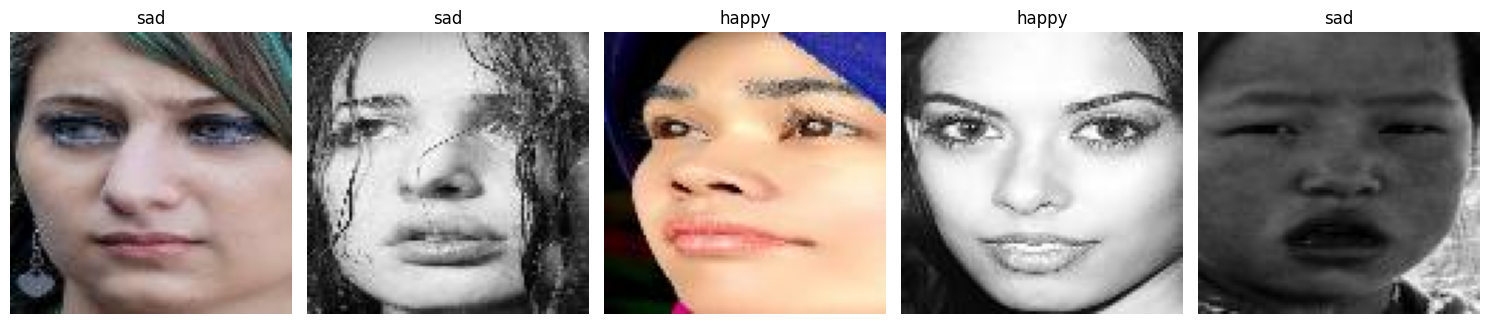

In [12]:
images = df['file_path'].head(5)

plt.figure(figsize=(15, 5))
for i, img_path in enumerate(images):
    img = cv2.imread(img_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.title(df['emotion_label'][i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Download and set Deepface model

In [14]:
# 2. Define a fast preprocessing function
# The model expects input shape: (48, 48, 1) and values normalized between 0-1
def preprocess_for_emotion(img_path):

      # Load image in grayscale (0 flag)
      img = cv2.imread(img_path)


      return img

# 3. Prepare the Data
# Assuming df contains your 'file_paths'
print("Preprocessing images...")

# Apply preprocessing to all images
image_data = df['file_path'].apply(preprocess_for_emotion)

image_data = np.array(image_data.tolist())
print("image data shape: ", image_data.shape)

Preprocessing images...
image data shape:  (12271, 100, 100, 3)


In [58]:
# build the model independent of the other structure
# model = DeepFace.build_model(task="facial_attribute", model_name="Emotion")
# model.predict(image_data[0])

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

correct label: sad
predicted labe: neutral



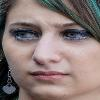

In [44]:
results = DeepFace.analyze(image_data[0], enforce_detection=False,  actions=['emotion'])
print(f'correct label: {df['emotion_label'][0]}\npredicted labe: {results[0]['dominant_emotion']}\n')
cv2_imshow(image_data[0])

In [62]:
#run on the whole dataset (takes 11 mins on cpu for training split)
results = DeepFace.analyze(image_data, enforce_detection=False,  actions=['emotion'])

In [65]:
len(results)

12271

In [70]:
#this cell saves the output of the model to your drive, incase you want to load it later
def convert_numpy_floats(obj):
    """
    Recursively converts numpy float32 objects to standard Python floats
    within dictionaries and lists.
    """
    if isinstance(obj, dict):
        return {k: convert_numpy_floats(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_floats(elem) for elem in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

# Define the output file path
output_dir = '/content/drive/MyDrive/drive_bys/'
output_filename = 'deepface_results.json'
output_filepath = os.path.join(output_dir, output_filename)

# Convert numpy.float32 to standard floats before saving
serializable_results = convert_numpy_floats(results)

# Save the results to a JSON file
with open(output_filepath, 'w') as f:
    json.dump(serializable_results, f, indent=4)

print(f"Results saved to: {output_filepath}")

Results saved to: /content/drive/MyDrive/drive_bys/deepface_results.json


In [28]:
results = json.load(open('/content/drive/MyDrive/drive_bys/deepface_results.json'))
len(results)

12271

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Define the exact order DeepFace uses (based on your output)
emotion_order = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# 2. Extract Probabilities from DeepFace Results
# results is the list of lists returned by DeepFace.analyze
# We divide by 100 because DeepFace returns 0-100, but sklearn expects 0-1
y_pred_proba = []

# Iterate through the results corresponding to your dataframe rows
for entry in results:
    # entry is a list of dicts (one per face). We take the first face [0].
    emotions_dict = entry[0]['emotion']

    # Extract values in the specific order
    probs = [emotions_dict[label] for label in emotion_order]
    y_pred_proba.append(probs)

# Convert to numpy array and normalize to 0-1 range
y_pred_proba = np.array(y_pred_proba) / 100.0

# 3. Prepare Ground Truth
# Map string labels from dataframe to integers (0-6) based on emotion_order
le = LabelEncoder()
le.fit(emotion_order) # Force the encoder to use our specific order
y_true = le.transform(df['emotion_label']) # Transform your DF labels

# Get hard predictions (Top-1 class index)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"Probability Matrix Shape: {y_pred_proba.shape}")

Probability Matrix Shape: (12271, 7)


In [31]:
# --- 1. Top-1 Accuracy ---
top1_acc = top_k_accuracy_score(y_true, y_pred_proba, k=1)

# --- 2. Top-3 Accuracy ---
top3_acc = top_k_accuracy_score(y_true, y_pred_proba, k=3)

# --- 3. F1 Score ---
# "Macro" gives equal weight to all classes (good for checking performance on rare emotions like disgust)
# "Weighted" accounts for class imbalance
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Per-class F1 breakdown
report = classification_report(y_true, y_pred, target_names=emotion_order)

print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print("-" * 30)
print("Per-Class Report:\n", report)

Top-1 Accuracy: 0.3872
Top-3 Accuracy: 0.6503
F1 Score (Macro): 0.2171
------------------------------
Per-Class Report:
               precision    recall  f1-score   support

       angry       0.24      0.43      0.31       705
     disgust       0.18      0.01      0.02       717
        fear       0.04      0.13      0.06       281
       happy       0.75      0.75      0.75      4772
         sad       0.25      0.16      0.19      2524
    surprise       0.04      0.01      0.01      1982
     neutral       0.12      0.31      0.17      1290

    accuracy                           0.39     12271
   macro avg       0.23      0.26      0.22     12271
weighted avg       0.39      0.39      0.37     12271



In [32]:
def compute_ece(y_true, y_pred_proba, n_bins=10):
    """
    Computes Expected Calibration Error (ECE) for multi-class classification.

    Args:
        y_true (array): True integer labels (N,)
        y_pred_proba (array): Predicted probabilities (N, C)
        n_bins (int): Number of bins for calibration
    """
    # 1. Get the max probability (confidence) and the predicted class for each sample
    confidences = np.max(y_pred_proba, axis=1)
    predictions = np.argmax(y_pred_proba, axis=1)

    # 2. Check correctness
    accuracies = (predictions == y_true)

    # 3. Define bin boundaries (0.0 to 1.0)
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    ece = 0.0
    total_samples = len(y_true)

    for i in range(n_bins):
        # Find samples that fall into this confidence bin
        lower = bin_boundaries[i]
        upper = bin_boundaries[i + 1]

        # Mask for samples in this bin
        in_bin = (confidences > lower) & (confidences <= upper)
        prop_in_bin = np.mean(in_bin) # Proportion of samples in this bin

        if prop_in_bin > 0:
            # Accuracy in this bin: mean(correctness)
            accuracy_in_bin = np.mean(accuracies[in_bin])

            # Confidence in this bin: mean(confidence)
            confidence_in_bin = np.mean(confidences[in_bin])

            # Absolute difference * weight
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin

    return ece

# Calculate ECE
ece_score = compute_ece(y_true, y_pred_proba, n_bins=15)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.4350


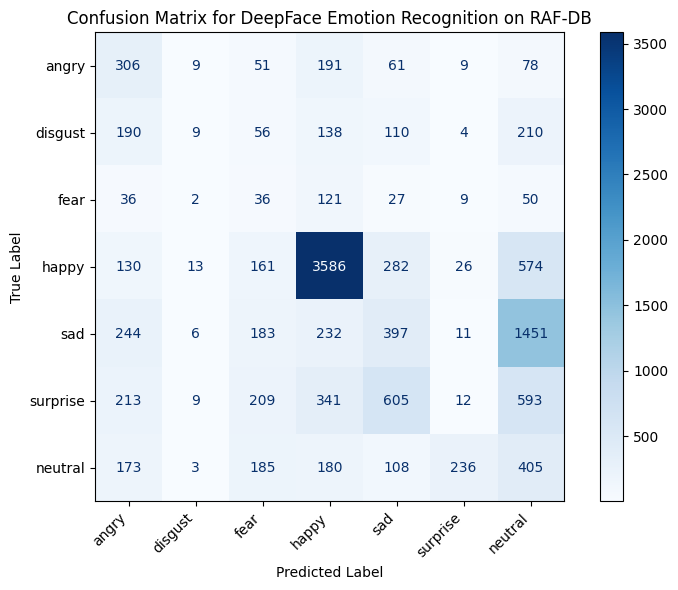

In [53]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get display labels (emotion_order is already defined in the notebook)
display_labels = emotion_order

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for DeepFace Emotion Recognition on RAF-DB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

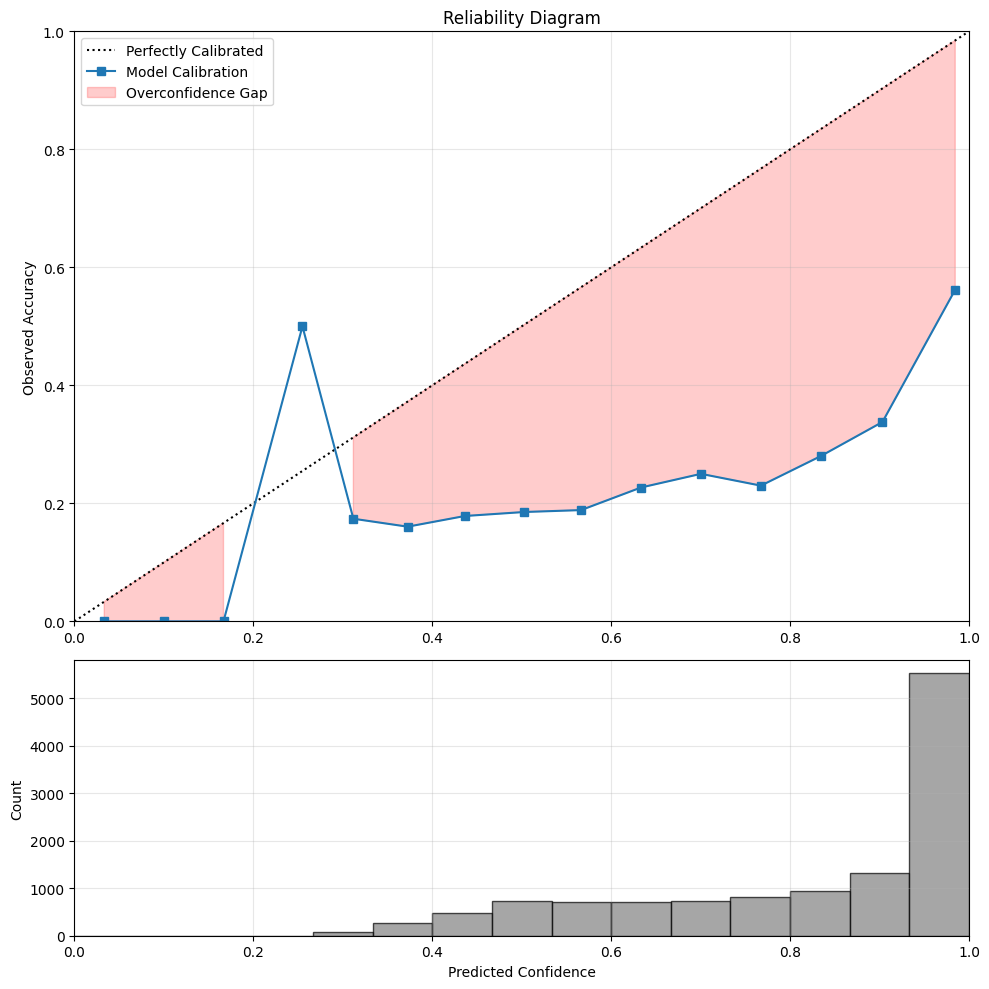

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_diagram(y_true, y_prob, n_bins=15, title="Reliability Diagram"):
    """
    Plots a multiclass reliability diagram.

    Args:
        y_true: Array of true class indices (0..N).
        y_prob: Array of predicted probabilities (N_samples, N_classes).
        n_bins: Number of bins for the calibration curve.
    """
    # 1. Get the Confidence (max prob) and Prediction for each sample
    confidences = np.max(y_prob, axis=1)
    predictions = np.argmax(y_prob, axis=1)

    # 2. Determine if prediction was correct
    accuracies = (predictions == y_true)

    # 3. Create Bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)

    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for i in range(n_bins):
        # Define bin range
        lower, upper = bin_boundaries[i], bin_boundaries[i+1]

        # Find samples in this bin
        in_bin = (confidences > lower) & (confidences <= upper)
        count = np.sum(in_bin)
        bin_counts.append(count)

        if count > 0:
            # Calculate average accuracy and confidence for this bin
            bin_accuracies.append(np.mean(accuracies[in_bin]))
            bin_confidences.append(np.mean(confidences[in_bin]))
        else:
            bin_accuracies.append(0)
            bin_confidences.append((lower + upper) / 2)

    # --- PLOTTING ---
    plt.figure(figsize=(10, 10))

    # Subplot 1: The Reliability Curve
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    # Perfect calibration line (Diagonal)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

    # The Model's curve
    ax1.plot(bin_confidences, bin_accuracies, "s-", label="Model Calibration")

    # Fill areas to highlight over/under confidence
    ax1.fill_between(bin_confidences, bin_confidences, bin_accuracies,
                     where=np.array(bin_accuracies) < np.array(bin_confidences),
                     color='red', alpha=0.2, label="Overconfidence Gap")

    ax1.set_ylabel("Observed Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, 1])
    ax1.set_title(title)
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Confidence Histogram (How many samples in each bin?)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax2.hist(confidences, bins=bin_boundaries, alpha=0.7, color='gray', edgecolor='black')
    ax2.set_xlabel("Predicted Confidence")
    ax2.set_ylabel("Count")
    ax2.set_xlim([0, 1])
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- USAGE ---
# y_true_indices: your integer ground truth (from previous step)
# y_pred_proba: your probability matrix (from previous step)

plot_reliability_diagram(y_true, y_pred_proba, n_bins=15)